Set up kaggle creditentals.

In [ ]:
import os
import pathlib
DRIVE_PATH = pathlib.Path("/content/drive/MyDrive/brain")
os.environ["KAGGLE_USERNAME"] = "" # add your username
os.environ["KAGGLE_KEY"] = "" # add your kaggle key

Download the dataset

In [3]:
import kaggle
kaggle.api.authenticate()
# https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset
kaggle.api.dataset_download_files("ashkhagan/figshare-brain-tumor-dataset", path="/content/data", unzip=True, quiet=True)

Dataset URL: https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset


Set up hyperparameters

In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class HyperParameters():
    SEGMENTATION_MODEL_PATH = DRIVE_PATH / "separated3UNet.pt"
    CLASSIFICATION_MODEL_PATH = DRIVE_PATH / "class.pt"
    CLASS_DATA_PATH = pathlib.Path("/content/class/")
    DATASET_PATH = pathlib.Path("/content/data/dataset/data")
    SEG_DATA_PATH = pathlib.Path("/content/seg")

    LEARNING_RATE = 0.0002
    EPOCHS = 40
    IMAGE_SIZE = 256
    BATCH_SIZE = 16

In [ ]:
!rm -rf /content/seg

Copy the mat files to training, validation and test folder.

Slices:
*   train: 2383
*   val: 360
*   test: 321



In [5]:
import shutil
import h5py
import numpy as np
(HyperParameters.SEG_DATA_PATH / "train").mkdir(exist_ok=True, parents=True)
(HyperParameters.SEG_DATA_PATH / "val").mkdir(exist_ok=True, parents=True)
(HyperParameters.SEG_DATA_PATH / "test").mkdir(exist_ok=True, parents=True)
patients = []
size = len(list(HyperParameters.DATASET_PATH.glob("*.mat")))
for i, mat_path in enumerate(HyperParameters.DATASET_PATH.glob("*.mat")):
    with h5py.File(mat_path, "r") as mat_file:
        pat_id = np.array([np.int8(x[0]) for x in mat_file["cjdata"]["PID"][:]]).tobytes().decode()
        if pat_id not in patients:
            patients.append(pat_id)
        sn = patients.index(pat_id) % 10
        purpose = "train"
        if sn == 8:
            purpose = "val"
        elif sn == 9:
            purpose = "test"
        new_path = HyperParameters.SEG_DATA_PATH / purpose
        shutil.copy(mat_path, new_path)
    if i % 200 == 0:
        print(f"{i/size*100:.1f}%")

0.0%
6.5%
13.1%
19.6%
26.1%
32.6%
39.2%
45.7%
52.2%
58.7%
65.3%
71.8%
78.3%
84.9%
91.4%
97.9%


Transformation

In [6]:
from torchvision.transforms import v2
import torch

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((256, 256)),
])

Custom Dataset class with the fetched information

In [ ]:
from torch.utils.data import Dataset
import pathlib
import numpy as np
from torchvision.transforms import v2
from typing import NamedTuple
import torch
import h5py
import torchvision.transforms.functional as TF

class BrainDiagnosis(NamedTuple):
    mask: torch.Tensor
    label: int

class BrainImageItem(NamedTuple):
    image: torch.Tensor
    mask: torch.Tensor
    label: int
    patient: str

class BrainImageDataset(Dataset):
    def __init__(self, path: pathlib.Path, transform: v2.Transform) -> None:
        self._slices: list[pathlib.Path] = []
        self._transform = transform
        self._class_mapping = {1: 0, 2: 1, 3: 2}

        for mat in path.glob("*.mat"):
            self._slices.append(mat)
        self._slices.sort(key=lambda i: i.name)

    def __getitem__(self, index) -> BrainImageItem:
        h5_path = self._slices[index]
        with h5py.File(h5_path, "r") as mat_file:
            image = self._transform(mat_file["cjdata"]["image"][:]).view((256, 256))
            mask = self._transform(mat_file["cjdata"]["tumorMask"][:])
            label = int(mat_file["cjdata"]["label"][0][0])
            patient = np.array([np.int8(x[0]) for x in mat_file["cjdata"]["PID"][:]]).tobytes().decode()

        label = self._class_mapping[label]

        image = TF.adjust_brightness(image, 6.0)

        mask = (mask > 0).float()

        image = torch.stack((image, image, image), dim=0)

        return BrainImageItem(image, mask, label, patient)

    def __len__(self) -> int:
        return len(self._slices)

train_ds = BrainImageDataset(HyperParameters.SEG_DATA_PATH / "train", transform)
val_ds = BrainImageDataset(HyperParameters.SEG_DATA_PATH / "val", transform)
test_ds = BrainImageDataset(HyperParameters.SEG_DATA_PATH / "test", transform)


Initialize data loaders

In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(dataset=train_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=True)

test_dl = DataLoader(dataset=test_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=False)

val_dl = DataLoader(dataset=val_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=False)

In [9]:
import collections
import torch
import torch.nn as nn
from torch.nn import functional as F

class BrainAnalyserModel(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    features = 32
    self.encoder1 = BrainAnalyserModel._block(3, features, name="enc1")
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder2 = BrainAnalyserModel._block(features, features * 2, name="enc2")
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder3 = BrainAnalyserModel._block(features * 2, features * 4, name="enc3")
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder4 = BrainAnalyserModel._block(features * 4, features * 8, name="enc4")
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.bottleneck = BrainAnalyserModel._block(features * 8, features * 16, name="bottleneck")

    # segmentation
    self.upconv4 = nn.ConvTranspose2d(
        features * 16, features * 8, kernel_size=2, stride=2
    )
    self.decoder4 = BrainAnalyserModel._block((features * 8) * 2, features * 8, name="dec4")
    self.upconv3 = nn.ConvTranspose2d(
        features * 8, features * 4, kernel_size=2, stride=2
    )
    self.decoder3 = BrainAnalyserModel._block((features * 4) * 2, features * 4, name="dec3")
    self.upconv2 = nn.ConvTranspose2d(
        features * 4, features * 2, kernel_size=2, stride=2
    )
    self.decoder2 = BrainAnalyserModel._block((features * 2) * 2, features * 2, name="dec2")
    self.upconv1 = nn.ConvTranspose2d(
        features * 2, features, kernel_size=2, stride=2
    )
    self.decoder1 = BrainAnalyserModel._block(features * 2, features, name="dec1")

    self.conv = nn.Conv2d(
        in_channels=features, out_channels=1, kernel_size=1
    )

    # classification
    self.fc1 = nn.Linear(features * 16 * 16 * 16, features * 4)
    self.bn = nn.BatchNorm1d(features * 4)
    self.fc2 = nn.Linear(features * 4, features * 2)
    self.fc3 = nn.Linear(features * 2, 3)

  def forward(self, x) -> BrainDiagnosis:
      enc1 = self.encoder1(x)
      enc2 = self.encoder2(self.pool1(enc1))
      enc3 = self.encoder3(self.pool2(enc2))
      enc4 = self.encoder4(self.pool3(enc3))

      bottleneck = self.bottleneck(self.pool4(enc4))

      # segmentation
      dec4 = self.upconv4(bottleneck)
      dec4 = torch.cat((dec4, enc4), dim=1)
      dec4 = self.decoder4(dec4)
      dec3 = self.upconv3(dec4)
      dec3 = torch.cat((dec3, enc3), dim=1)
      dec3 = self.decoder3(dec3)
      dec2 = self.upconv2(dec3)
      dec2 = torch.cat((dec2, enc2), dim=1)
      dec2 = self.decoder2(dec2)
      dec1 = self.upconv1(dec2)
      dec1 = torch.cat((dec1, enc1), dim=1)
      dec1 = self.decoder1(dec1)
      seg = torch.sigmoid(self.conv(dec1))

      # classification
      cl = bottleneck.view(-1, 32 * 16 * 16 * 16)
      cl = F.relu(self.bn(self.fc1(cl)))
      cl = F.relu(self.fc2(cl))
      cl = F.log_softmax(self.fc3(cl), dim=1)

      return BrainDiagnosis(seg, cl)

  @staticmethod
  def _block(in_channels, features, name):
      return nn.Sequential(
          collections.OrderedDict(
              [
                  (
                      name + "conv1",
                      nn.Conv2d(
                          in_channels=in_channels,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                  ),
                  (name + "norm1", nn.BatchNorm2d(num_features=features)),
                  (name + "relu1", nn.ReLU(inplace=True)),
                  (
                      name + "conv2",
                      nn.Conv2d(
                          in_channels=features,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                  ),
                  (name + "norm2", nn.BatchNorm2d(num_features=features)),
                  (name + "relu2", nn.ReLU(inplace=True)),
              ]
          )
      )

Load a trained model (Optional)

In [10]:
net = BrainAnalyserModel()
if device == "cuda:0":
    net.load_state_dict(torch.load("/content/drive/MyDrive/brain/Ynet.pt", weights_only=True))
else:
    net.load_state_dict(torch.load("/content/drive/MyDrive/brain/Ynet.pt", map_location=torch.device('cpu'), weights_only=True))
net.to(device)
print("Model loaded")

Model loaded


Definition of Dice Loss

In [11]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size(), f"pred: {y_pred.size()}, true: {y_true.size()}"
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2.0 * intersection + 1.0) / (y_pred.sum() + y_true.sum() + 1.0)
        return 1.0 - dsc

Initialize the network, loss and optimizer.

In [10]:
import torch

net = BrainAnalyserModel()
net = net.to(device)

dice_loss_func = DiceLoss().to(device)
cross_entropy_loss_func = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=HyperParameters.LEARNING_RATE)

Helper function for training.

In [15]:
def log_summary(loss_list1: list[float], loss_list2: list[float], prefix=""):
    sum = np.mean([loss_list1[i] + loss_list2[i] for i in range(len(loss_list1))])
    print(f"{prefix}loss: {sum}, segmentation: {np.mean(loss_list1)}, classification: {np.mean(loss_list2)}\n")

def add_loss_by_patient(loss: dict[str, list[float]],
                        id: list[str],
                        loss_func: nn.Module,
                        y_pred: list[torch.Tensor],
                        y_true: list[torch.Tensor]):
    for i, patient_id in enumerate(id):
            if patient_id not in loss:
                loss.setdefault(patient_id, [])
            l = loss_func(y_pred[i], y_true[i])
            loss[patient_id].append(l.detach().cpu().numpy())

Training

In [13]:
dice_loss_train: dict[str, list[float]] = {}
dice_loss_valid: dict[str, list[float]] = {}
ce_loss_train: dict[str, list[float]] = {}
ce_loss_valid: dict[str, list[float]] = {}
history: dict[str, list[float | dict]] = {"d_train": [], "d_valid": [], "ce_train": [], "ce_valid": [], "valid": [], "model": []}

for epoch in range(HyperParameters.EPOCHS):
    print(f"===== EPOCH {epoch} =====\n")

    # training
    for i, data in enumerate(train_dl):

        x, y_true_mask, y_true_label, patient_id = data
        x, y_true_mask, y_true_label = x.to(device), y_true_mask.to(device), y_true_label.to(device)
        net.train()
        optimizer.zero_grad()

        y_pred_mask, y_pred_label = net(x)

        dice_loss = dice_loss_func(y_pred_mask, y_true_mask)
        ce_loss = cross_entropy_loss_func(y_pred_label, y_true_label)
        loss = dice_loss + ce_loss

        add_loss_by_patient(dice_loss_train, patient_id, dice_loss_func, y_pred_mask, y_true_mask)
        add_loss_by_patient(ce_loss_train, patient_id, cross_entropy_loss_func, y_pred_label, y_true_label)
        loss.backward()
        optimizer.step()

    # train loss
    dice_patient_loss = []
    ce_patient_loss = []
    for patient in dice_loss_train:
        dice_patient_loss.append(np.mean(dice_loss_train[patient]))
        ce_patient_loss.append(np.mean(ce_loss_train[patient]))

    log_summary(dice_patient_loss, ce_patient_loss, prefix="train_")
    history["d_train"].append(np.mean(dice_patient_loss))
    history["ce_train"].append(np.mean(ce_patient_loss))
    dice_loss_train = {}
    ce_loss_train = {}

    # validation
    for i, valid_data in enumerate(val_dl):
        x, y_true_mask, y_true_label, patient_id = valid_data
        x, y_true_mask, y_true_label = x.to(device), y_true_mask.to(device), y_true_label.to(device)

        net.eval()
        optimizer.zero_grad()

        with torch.no_grad():
            y_pred_mask, y_pred_label = net(x)

        add_loss_by_patient(dice_loss_valid, patient_id, dice_loss_func, y_pred_mask, y_true_mask)
        add_loss_by_patient(ce_loss_valid, patient_id, cross_entropy_loss_func, y_pred_label, y_true_label)

    # valid loss
    dice_patient_loss = []
    ce_patient_loss = []
    for patient in dice_loss_valid:
        dice_patient_loss.append(np.mean(dice_loss_valid[patient]))
        ce_patient_loss.append(np.mean(ce_loss_valid[patient]))

    log_summary(dice_patient_loss, ce_patient_loss, prefix="val_")
    history["d_valid"].append(np.mean(dice_patient_loss))
    history["ce_valid"].append(np.mean(ce_patient_loss))
    history["valid"].append(history["d_valid"][-1] + history["ce_valid"][-1])
    history["model"].append(net.state_dict())
    dice_loss_valid = {}
    ce_loss_valid = {}

    if (epoch > 3
        and history["valid"][-1] > history["valid"][-2]
        and history["valid"][-1] > history["valid"][-3]
        and history["valid"][-1] > history["valid"][-4]):
        break

best_model = history["valid"].index(min([loss.sum() for loss in history["valid"]]))
print(f"Best model: {best_model}")
net.load_state_dict(history["model"][best_model])

===== EPOCH 0 =====

train_loss: 1.6092870235443115, segmentation: 0.987152099609375, classification: 0.6221349239349365

val_loss: 1.3825091123580933, segmentation: 0.9838265776634216, classification: 0.3986824154853821

===== EPOCH 1 =====

train_loss: 1.3535977602005005, segmentation: 0.9766274094581604, classification: 0.3769703209400177

val_loss: 1.4145779609680176, segmentation: 0.9705901145935059, classification: 0.44398775696754456

===== EPOCH 2 =====

train_loss: 1.224308729171753, segmentation: 0.9567742347717285, classification: 0.2675343453884125

val_loss: 1.2435493469238281, segmentation: 0.941785454750061, classification: 0.30176377296447754

===== EPOCH 3 =====

train_loss: 1.118172287940979, segmentation: 0.9118107557296753, classification: 0.20636138319969177

val_loss: 1.0784497261047363, segmentation: 0.8764433860778809, classification: 0.20200639963150024

===== EPOCH 4 =====

train_loss: 0.9871158599853516, segmentation: 0.8240387439727783, classification: 0.163

<All keys matched successfully>

Saving model (Optional)

In [16]:
torch.save(net.state_dict(), "/content/drive/MyDrive/brain/Ynet.pt")

Plot training loss

In [ ]:
import matplotlib.pyplot as plt
history["train"] = [history["train_d"][i] + history["train_ce"][i] for i in range(len(history["train_d"]))]
x_label = [int(x) for x in range(1, len(history["train"]) + 1)]
fig, ax = plt.subplots(1,3, figsize=(14, 4))
ax[0].plot(x_label, history["train"], label="train")
ax[0].plot(x_label, history["valid"], label="validation")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_title("Aggregated loss")
ax[0].legend()

ax[1].plot(x_label, history["d_train"], label="train")
ax[1].plot(x_label, history["d_valid"], label="validation")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Dice loss")
ax[1].set_title("Segmentation loss")
ax[1].legend()

ax[2].plot(x_label, history["ce_train"], label="train")
ax[2].plot(x_label, history["ce_valid"], label="validation")
ax[2].set_xlabel("epoch")
ax[2].set_ylabel("cross entropy loss")
ax[2].set_title("Classification loss")
ax[2].legend()

plt.show()

Helper functions

In [ ]:
from operator import imod
import matplotlib.pyplot as plt
import matplotlib.patches
import torch
import torch.nn as nn

def show_image(image_ds: BrainImageDataset, index: int) -> None:
    plt.imshow(np.squeeze(image_ds[index].image).T)
    plt.title(image_ds[index].patient)

def show_mask(image_ds: BrainImageDataset, index: int) -> None:
    plt.imshow(np.squeeze(image_ds[index].mask).T, cmap="gray")
    plt.title(image_ds[index].patient)

def show_prediction(image_ds: BrainImageDataset,
                    index: int,
                    net: nn.Module,
                    threshold=0.8) -> None:
    fig, ax = plt.subplots(2, 2)

    ax[0, 0].imshow(np.squeeze(image_ds[index].image).T)
    ax[0, 0].set_title(image_ds[index].patient)
    _remove_ticklabels(ax[0, 0])

    true = np.squeeze(image_ds[index].mask).T
    ax[0, 1].imshow(true, cmap="gray")
    ax[0, 1].set_title("ground truth")
    _remove_ticklabels(ax[0, 1])

    x = image_ds[index].image.view((1,3,256,256)).to(device)
    with torch.no_grad():
        preds = net(x)
    prediction = preds.detach().cpu().numpy()
    prediction = np.squeeze(prediction[0]).T
    ax[1, 0].imshow(prediction, cmap="gray")
    ax[1, 0].set_title("prediction")
    _remove_ticklabels(ax[1, 0])

    empty_image_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    for i in range(0, 256):
      for j in range(0, 256):
        if true[i, j] > 0.5:
          empty_image_rgb[i, j, 0] = 255
        if prediction[i, j] > threshold:
          empty_image_rgb[i, j, 1] = 255


    ax[1, 1].imshow(empty_image_rgb)
    ax[1, 1].set_title("prediction overlay")
    ax[1, 1].text(-120, 20, "ground truth", color="red", fontsize=8)
    ax[1, 1].text(-120, 35, "prediction", color="green", fontsize=8)
    ax[1, 1].text(-120, 50, "overlay", color="yellow", fontsize=8)
    _remove_ticklabels(ax[1, 1])

def show_segmentation(
    image_ds: BrainImageDataset,
    index: int,
    net: nn.Module,
    threshold=0.8
):
    image_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    # image = TF.adjust_brightness(image_ds[index].image, 6.0)
    brain_image = np.squeeze(image_ds[index].image).T
    brain_mask = np.squeeze(image_ds[index].mask).T
    input = image_ds[index].image.view((1,3,256,256)).to(device)
    with torch.no_grad():
        preds = net(input)
    prediction = preds.detach().cpu().numpy()
    prediction = np.squeeze(prediction[0]).T
    image_rgb[:, :, 0] = brain_image[:, :, 1] * 255
    image_rgb[:, :, 1] = brain_image[:, :, 1] * 255
    image_rgb[:, :, 2] = brain_image[:, :, 1] * 255

    for i in range(0, 256):
        for j in range(0, 256):
            _draw_outline(brain_mask, image_rgb, i, j, color="red")
            _draw_outline(prediction, image_rgb, i, j, color="green", th=threshold)

    plt.imshow(image_rgb)
    plt.title(image_ds[index].patient)

def _remove_ticklabels(ax) -> None:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

def _draw_outline(mask, output, i ,j, color, th=0.5):
    channel = 0
    if color == "green":
        channel = 1
    if color == "blue":
        channel = 2
    if mask[i, j] > th:
        if i == 0 or j == 0 or i == 255 or j == 255:
            output[i, j, channel] = 255
        elif (mask[i-1, j] < th or mask[i+1, j] < th or
              mask[i, j-1] < th or mask[i, j+1] < th):
            output[i, j, channel] = 255

## Test the segmentation

In [16]:
dice_loss = DiceLoss()
loss_dice = []
test_dice_loss = {}
for i, data in enumerate(test_dl):
  x, y_true, _, info = data
  x, y_true = x.to(device), y_true.to(device)
  with torch.no_grad():
    y_pred, _ = net(x)
    loss_dice.append(dice_loss(y_pred, y_true).detach().cpu().numpy())
    add_loss_by_patient(test_dice_loss, info, dice_loss, y_pred, y_true)
print(f"One by one loss values: dice loss: {np.mean([np.mean(v) for k,v in test_dice_loss.items()])}")
print(f"batch by batch loss values: dice loss: {np.mean(loss_dice)}")
for patient in test_dice_loss:
    print(f"Patient {patient}: dice loss: {np.mean(test_dice_loss[patient])}")

One by one loss values: dice loss: 0.04252324253320694
batch by batch loss values: dice loss: 0.31036409735679626
Patient 107743: dice loss: 0.05151310935616493
Patient 109769: dice loss: 0.06200608238577843
Patient 109898: dice loss: 0.056835416704416275
Patient 110537: dice loss: 0.060260359197854996
Patient 108550: dice loss: 0.06010804697871208
Patient 110116: dice loss: 0.04237937927246094
Patient 101145: dice loss: 0.05278034135699272
Patient 102648: dice loss: 0.044185858219861984
Patient 112002: dice loss: 0.036658238619565964
Patient MR049942B: dice loss: 0.04606835916638374
Patient MR040240B: dice loss: 0.03716422989964485
Patient MR024780B: dice loss: 0.03721648454666138
Patient MR026175E: dice loss: 0.03605388477444649
Patient 102929: dice loss: 0.036227717995643616
Patient MR049242C: dice loss: 0.040976595133543015
Patient MR053241C: dice loss: 0.04206831753253937
Patient 105374: dice loss: 0.03258241340517998
Patient 106914: dice loss: 0.03478066623210907
Patient 100639: 

## Test the classification

In [ ]:
!rm -rf /content/class

Create the folder structure for classification

Load previous model

In [ ]:
net = BrainAnalyserModel()
if device == "cuda:0":
    net.load_state_dict(torch.load(HyperParameters.CLASSIFICATION_MODEL_PATH, weights_only=True))
else:
    net.load_state_dict(torch.load("/content/drive/MyDrive/brain/Ynet.pt", map_location=torch.device('cpu'), weights_only=True))
net.to(device)
print("Model loaded")

Model loaded


In [ ]:
import numpy as np
import torch

criterion = torch.nn.CrossEntropyLoss()
class_count = 3
classes = [
    "meningioma_tumor",
    "glioma_tumor",
    "pituitary_tumor",
]

test_loss = 0.0
class_correct = [0.0] * class_count
class_total = [0.0] * class_count
points = np.array([[0] * class_count for _ in range(class_count)], np.int32)

for data in test_dl:
    image, target_cuda = data.image.to(device), data.label.to(device)
    # forward pass
    _, output = net(image)
    # batch loss
    loss = criterion(output, target_cuda)
    # test loss update
    test_loss += loss.item() * image.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target_cuda.data.view_as(pred))
    correct = np.squeeze(correct_tensor.detach().cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data.label)):
        label = data.label.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        points[int(pred.data[i]), int(label)] += 1

# average test loss
test_loss = test_loss / len(test_dl.dataset)
print(f"Test Loss: {test_loss:.4f}")

for i, label in enumerate(classes):
    if class_total[i] > 0:
        print(f"Test Accuracy of {label}: {100*class_correct[i]/class_total[i]:.3f}%")
    else:
        print(f"Test Accuracy of {label}s: N/A (no training examples)")

print(
    f"Full Test Accuracy: {round(100. * np.sum(class_correct) / np.sum(class_total), 2)}\
    % {np.sum(class_correct)} out of {np.sum(class_total)}"
)

Test Loss: 1.8551
Test Accuracy of meningioma_tumor: 73.684%
Test Accuracy of glioma_tumor: 78.740%
Test Accuracy of pituitary_tumor: 47.727%
Full Test Accuracy: 67.65    % 184.0 out of 272.0


Text(0.5, 1.0, 'Accuracy')

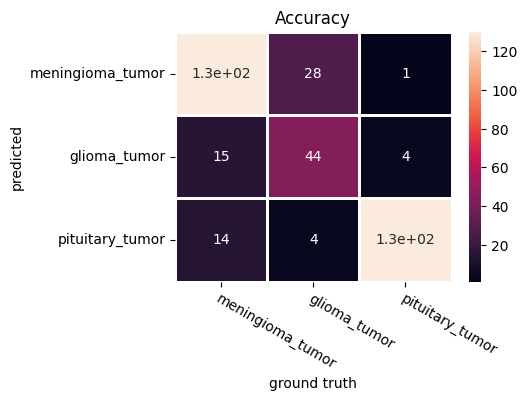

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.heatmap(points, linewidths=1, annot=True, xticklabels=classes, yticklabels=classes)
plt.subplots_adjust(left=0.36, bottom=0.36)
plt.xlabel("ground truth")
plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
plt.yticks(rotation=0, ha="right", rotation_mode="anchor")
plt.ylabel("predicted")
plt.title(f"Accuracy")